# [helpful link](https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
import torchsummary
from torchsummary import summary
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import time
import copy



In [2]:
#loading data 1

data_dir = os.path.join('.', 'data')

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor()])

image_dataset = datasets.ImageFolder(data_dir, transform=data_transform)

dataloader = torch.utils.data.DataLoader(
        image_dataset, batch_size=32,
        shuffle=True, num_workers=4)

dataset_size = len(image_dataset)

print("Loaded images under {}".format(dataset_size))
    
print("Classes: ")
class_names = image_dataset.classes
print(image_dataset.classes)


Loaded images under 5539
Classes: 
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


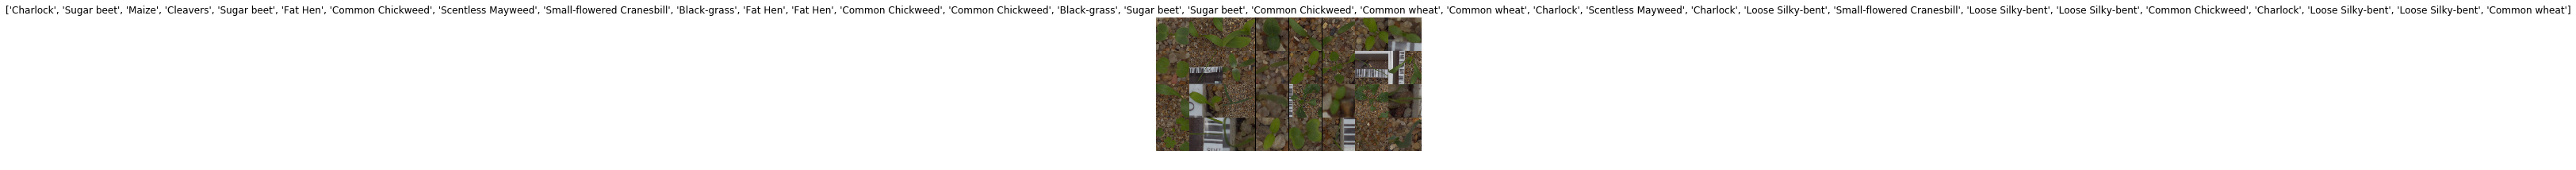

In [3]:
# loading data 2

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloader))
show_databatch(inputs, classes)

In [4]:
# loading data 3
def indicesSplit(ds, k):
    train_indices = []
    test_indices = []
    class_counts = {}
    
    for i in range(len(ds)):
        label_index = ds[i][1]
        class_counts[label_index] = class_counts.get(label_index, 0) + 1
        
        if class_counts[label_index] <= k:
            train_indices.append(i)
        else:
            test_indices.append(i)
    return train_indices, test_indices


In [5]:
# loading data 4
k = int(252*.9)

train_indices, test_indices = indicesSplit(image_dataset, int(252*.9))

In [6]:
# loading data 5

train_ds = Subset(image_dataset, train_indices)
test_ds = Subset(image_dataset, test_indices)
train_dataloader = DataLoader(
        train_ds, batch_size=32,
        shuffle=True, num_workers=4
    )
test_dataloader = DataLoader(
        test_ds, batch_size=32,
        shuffle=True, num_workers=4
    )

In [7]:
vgg16 = models.vgg16(pretrained=True)

In [8]:
def freeze_layers(model):
    for param in model.parameters():
        param.requires_grad = False

In [9]:
freeze_layers(vgg16)
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

In [10]:
summary(vgg16, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [11]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        size = inputs.size()[0]
        
        inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [12]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    n = 0
    
    test_batches = len(test_dataloader)
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(test_dataloader):
        print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        inputs, labels = Variable(inputs), Variable(labels)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels)
        
        n += len(preds)
        loss_test += loss.data.item()
        acc_test += torch.sum(preds == labels).item()

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / n
    avg_acc = acc_test / n
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [13]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [74]:
print("Test before training")
eval_model(vgg16, criterion)

Test before training
Evaluating model
----------
Test batch 1/89

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/wchlhyun/anaconda3/envs/CDS/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/wchlhyun/anaconda3/envs/CDS/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/wchlhyun/anaconda3/envs/CDS/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/wchlhyun/anaconda3/envs/CDS/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/wchlhyun/anaconda3/envs/CDS/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/wchlhyun/anaconda3/envs/CDS/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/wchlhyun/anaconda3/envs/CDS/lib/

KeyboardInterrupt: 

In [33]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    n_train = 0
    n_val = 0

    
    train_batches = len(train_dataloader)
    val_batches = len(test_dataloader)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(train_dataloader):
            print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
                
            inputs, labels = data
            
            inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            n_train += len(preds)
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss = loss_train / n_train
        avg_acc = acc_train / n_train
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(test_dataloader):
            print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data

            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            n_train += len(preds)
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / n_train
        avg_acc_val = acc_val / n_train
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [ ]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)
torch.save(vgg16.state_dict(), 'VGG16_v2-OCT_Retina_half_dataset.pt')

Epoch 0/2
----------
Training batch 48/85

In [ ]:
eval_model(vgg16, criterion)